In [2]:
# Standard Imports
import numpy as np
from time import time
import pandas as pd
from matplotlib import pyplot as plt

# SHAPER
from src.Observables import Observable
from src.Shaper import Shaper
from src.Manifolds import Coordinates2D, Simplex

# Utils
from utils.data_utils import load_dataset
from utils.plot_utils import plot_event

# Jets
from pyjet import cluster


# Data

(50000, 200, 3)
(50000, 200, 3)


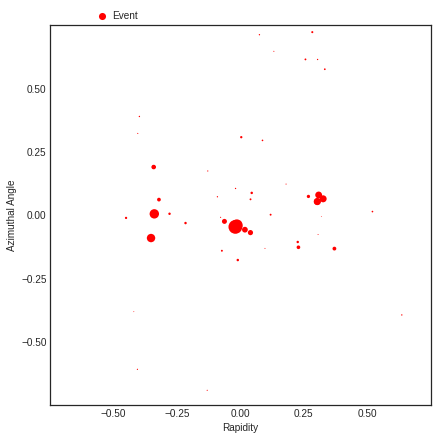

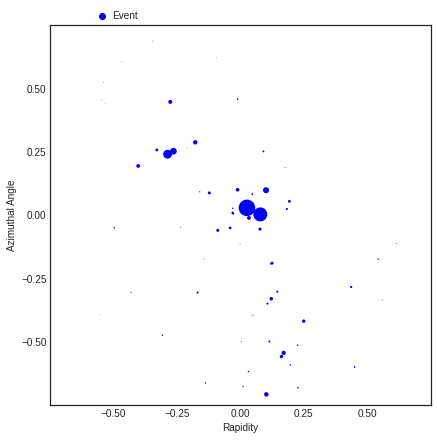

<AxesSubplot:xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [3]:
# Parameters
R = 0.5
beta = 1.0
N = 500
epochs = 75
mass_lower = 145
mass_upper = 205
eta_cut = 1.3
plot_dir = "results"



signal, signal_masses = load_dataset("../Datasets/top/v0/signal_train.npy", N, mass_lower, mass_upper, eta_cut)
background, background_masses = load_dataset("../Datasets/top/v0/background_train.npy", N, mass_lower, mass_upper, eta_cut)
events = [signal, background]
event_labels = ["signal", "background"]
colors = ["red", "blue"]


fake_top, fake_top_z = np.array(( (-1.0,0.0), (0.0,0.0), (1.0,0.0),)), np.array((1/3, 1/3, 1/3))
fake_signal = ((fake_top, fake_top_z), )
fake_quark, fake_quark_z = np.array(((0.0,0.0),)), np.array((1.0, ))
fake_background = ((fake_quark, fake_quark_z),)
fake_events = [fake_signal, fake_background]


# Example plots
example_signal = signal[0]
plot_event(example_signal[0], example_signal[1], R, color = "red")

example_background = background[0]
plot_event(example_background[0], example_background[1], R, color = "blue")


In [8]:
import torch 
import torch.nn as nn


# Sample from a normalized uniform distribution
def uniform_sampler(N, param_dict):
    points = torch.FloatTensor(N, 2).uniform_(-0.8, 0.8)
    zs = torch.ones((N,)) / N
    return (points, zs)

# Sample at N weighted Dirac deltas
def point_sampler(N, param_dict):
    return (param_dict["Points"].params, param_dict["Weights"].params)

# Basic Observables
_isotropy = Observable({}, uniform_sampler, beta = 1, R = 0.8)
_1subjettiness = Observable({"Points" : Coordinates2D(1), "Weights" : Simplex(1)}, point_sampler, beta = 1, R = 0.8, initializer= "kt")
_2subjettiness = Observable({"Points" : Coordinates2D(2), "Weights" : Simplex(2)}, point_sampler, beta = 1, R = 0.8, initializer= "kt")
_3subjettiness = Observable({"Points" : Coordinates2D(3), "Weights" : Simplex(3)}, point_sampler, beta = 1, R = 0.8, initializer= "kt")
_MAXsubjettiness = Observable({"Points" : Coordinates2D(200), "Weights" : Simplex(200)}, point_sampler, beta = 1, R = 0.8, initializer= "kt")

# # Composite Observables
# _3subjettiness_plus_pileup = _3subjettiness + _isotropy
rho = 0.1
_apollonius = (_MAXsubjettiness + _isotropy)
_apollonius.freeze("Joint Weights", np.array([1 - rho, rho]))


# List of observables we want to calculate
observables = {
    # "Isotropy" : _isotropy,
    "1 Subjettiness" : _1subjettiness,
    "2 Subjettiness" : _2subjettiness,
    "3 Subjettiness" : _3subjettiness,
    # "MAX Subjettiness" : _MAXsubjettiness,
    # "3 Subjettiness + Pileup" : _3subjettiness_plus_pileup,
    # "Apollonius" : _apollonius
}
shaper = Shaper(observables)


signal_emds, signal_params = shaper.calculate(signal, epochs = 500, verbose=True, lr = 0.01, scaling = 0.25, epsilon = 0.01, early_stopping= 25)
background_emds, background_params = shaper.calculate(background, epochs = 500, verbose=True, lr = 0.01, scaling = 0.25, epsilon= 0.01, early_stopping= 25)



[('params.Points.params', Parameter containing:
tensor([[-7.1616e-01, -5.2364e-01],
        [ 6.9159e-01, -5.4170e-02],
        [ 9.5313e-01,  7.2778e-02],
        [-7.8004e-01,  6.0066e-01],
        [-8.5777e-02,  8.3435e-02],
        [ 5.1254e-01,  6.8439e-01],
        [ 6.3220e-01,  2.0519e-01],
        [ 2.3702e-01,  2.2955e-01],
        [-9.2168e-01, -2.3971e-01],
        [ 6.7241e-01,  8.5359e-01],
        [-2.9916e-01,  6.4647e-01],
        [ 3.1219e-01,  7.6135e-01],
        [-9.3715e-01, -7.6044e-04],
        [-5.8390e-01, -6.9769e-01],
        [-5.6827e-01,  9.5916e-01],
        [-6.5672e-03,  8.9077e-01],
        [-3.1701e-01,  4.3113e-01],
        [ 4.2407e-01, -6.4096e-01],
        [ 2.3536e-01, -7.3194e-01],
        [-2.8246e-01,  2.0772e-01],
        [ 6.4910e-01,  4.7055e-01],
        [ 5.6393e-01, -5.7242e-02],
        [ 8.5144e-02, -7.8620e-02],
        [ 4.2897e-02,  7.7931e-01],
        [-3.9979e-01,  7.2151e-01],
        [-8.8065e-01, -4.0954e-01],
        [-4.8851

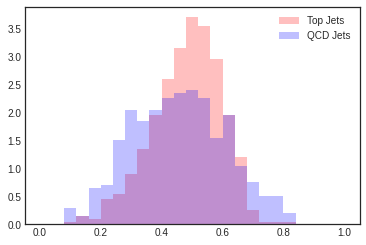

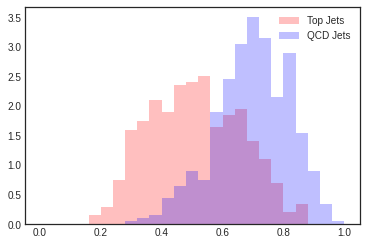

In [ ]:
plt.hist(signal_emds["2 Subjettiness"] / signal_emds["1 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "red", histtype="stepfilled", alpha = 0.25, label = "Top Jets")
plt.hist(background_emds["2 Subjettiness"] / background_emds["1 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "blue", histtype="stepfilled", alpha = 0.25, label = "QCD Jets")
plt.legend()
plt.show()

plt.hist(signal_emds["3 Subjettiness"] / signal_emds["2 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "red", histtype="stepfilled", alpha = 0.25, label = "Top Jets")
plt.hist(background_emds["3 Subjettiness"] / background_emds["2 Subjettiness"] , bins = 25, range = [0,1], density = True, color = "blue", histtype="stepfilled", alpha = 0.25, label = "QCD Jets")
plt.legend()

# Benchmarks - Apollonius

In [5]:
# Interpolate between max subjettiness, ---rhos--- isotropy
rhos = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
observables = {"MAX Subjettiness": _MAXsubjettiness}
for rho in rhos:
    _apollonius = (_MAXsubjettiness + _isotropy)
    _apollonius.freeze("Joint Weights", np.array([1 - rho, rho]))
    observables["Apollonius %d" % (rho * 10)] = _apollonius
observables["Isotropy"] = _isotropy

shaper = Shaper(observables)

# print(signal[0][1])
signal_emds, signal_params = shaper.calculate(signal, epochs = 500, verbose=True, lr = 0.01, scaling = 0.5, epsilon = 0.01, early_stopping= 5)
background_emds, background_params = shaper.calculate(background, epochs = 500, verbose=True, lr = 0.01, scaling = 0.5, epsilon= 0.01, early_stopping= 5)

Observable: MAX Subjettiness Epoch 0 Mean Loss = -3.924383040754264e-14 Elapsed time = 10.253s Percentage done = 0.000 
Observable: MAX Subjettiness Epoch 1 Mean Loss = 4.0491009131073955e-06 Elapsed time = 14.271s Percentage done = 0.000 
Observable: MAX Subjettiness Epoch 2 Mean Loss = 4.0491009131073955e-06 Elapsed time = 18.273s Percentage done = 0.000 
Observable: MAX Subjettiness Epoch 3 Mean Loss = 4.0491009131073955e-06 Elapsed time = 22.138s Percentage done = 0.000 
Observable: MAX Subjettiness Epoch 4 Mean Loss = 4.0491009131073955e-06 Elapsed time = 26.045s Percentage done = 0.000 
Observable: MAX Subjettiness Epoch 5 Mean Loss = 4.0491009131073955e-06 Elapsed time = 30.164s Percentage done = 0.000 
Observable: Apollonius 0 Epoch 0 Mean Loss = 4.0491009131073955e-06 Elapsed time = 12.941s Percentage done = 0.000 
Observable: Apollonius 0 Epoch 1 Mean Loss = 9.034250676631928e-05 Elapsed time = 25.440s Percentage done = 0.000 
Observable: Apollonius 0 Epoch 2 Mean Loss = 9.03

KeyboardInterrupt: 

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

Text(0.5, 1.0, 'Apollonius EMD Distribution')

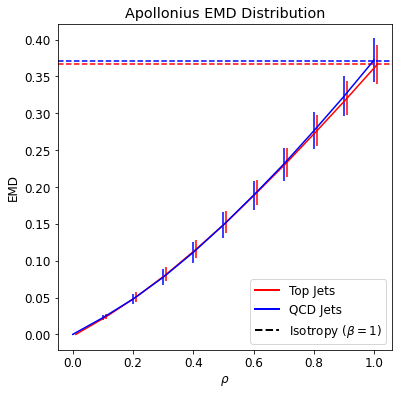

In [ ]:
from matplotlib.lines import Line2D

plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'

sg_ys = []
sg_errs = []
bg_ys = []
bg_errs = []

# print(signal_emds, background_emds)

for (i, rho) in enumerate(rhos):
    print(background_emds["Apollonius %d" %i])
    sg_ys.append(np.mean(signal_emds["Apollonius %d" %i]))
    sg_errs.append(np.std(signal_emds["Apollonius %d" %i]))
    bg_ys.append(np.mean(background_emds["Apollonius %d" %i]))
    bg_errs.append(np.std(background_emds["Apollonius %d" %i]))

plt.errorbar(np.array(rhos) + 0.01, sg_ys, yerr = sg_errs, color = "red", label = "Top Jets")
plt.errorbar(rhos, bg_ys, yerr = bg_errs, color = "blue", label = "QCD Jets")

# plt.axhline(np.mean(signal_emds["MAX Subjettiness"]), color = "black")
plt.axhline(np.mean(signal_emds["Isotropy"] * 0.95), color = "red", linestyle = "--")
plt.axhline(np.mean(background_emds["Isotropy"] * 0.94), color = "blue", linestyle = "--")


custom_legend = [Line2D([0], [0], color = "red", lw = 2, label = "Top Jets"),
                 Line2D([0], [0], color = "blue", lw = 2, label = "QCD Jets"),
                 Line2D([0], [0], color = "black", lw = 2, ls = "--", label = r"Isotropy $(\beta = 1)$"),]
plt.legend(handles = custom_legend)
plt.xlabel(r"$\rho$")
plt.ylabel("EMD")
plt.title("Apollonius EMD Distribution")

# TODO: Make rainbow plot CMS vs Pythia plot of N-subjettiness for many Ns 

In [ ]:
# How far is each event from its (normalized) corrected event?

for rho in rhos:
    observables["Apollonius %d" % (rho * 10)].freeze("Weights")
    observables["Apollonius %d" % (rho * 10)].freeze("Joint Weights")

# Benchmarks - Nsubjettiness

In [ ]:
# Interpolate between max subjettiness, ---rhos--- isotropy
N = range(1,151)
observables = {}
for n in N:

    _nsubjettiness = Observable({"Points" : Coordinates2D(n), "Weights" : Simplex(n)}, point_sampler, beta = 1, R = 0.8, initializer= "kt")
    observables["%d-Subjettiness" % n] = _nsubjettiness

shaper = Shaper(observables)

# print(signal[0][1])
signal_emds, signal_params = shaper.calculate(signal, epochs = 500, verbose=True, lr = 0.01, scaling = 0.5, epsilon = 0.01, early_stopping= 5)
background_emds, background_params = shaper.calculate(background, epochs = 500, verbose=True, lr = 0.01, scaling = 0.5, epsilon= 0.01, early_stopping= 5)

Observable: 1-Subjettiness Epoch 0 Mean Loss = 0.22555273923277855 Elapsed time = 2.859s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 1 Mean Loss = 0.22267263697087764 Elapsed time = 3.907s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 2 Mean Loss = 0.22072906582057475 Elapsed time = 4.753s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 3 Mean Loss = 0.21954030138254166 Elapsed time = 5.604s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 4 Mean Loss = 0.21873858788609504 Elapsed time = 6.454s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 5 Mean Loss = 0.21810977770388126 Elapsed time = 7.306s Percentage done = 0.000 
Observable: 1-Subjettiness Epoch 6 Mean Loss = 0.2176129227876663 Elapsed time = 8.141s Percentage done = 4.000 
Observable: 1-Subjettiness Epoch 7 Mean Loss = 0.21722040393948555 Elapsed time = 8.926s Percentage done = 13.600 
Observable: 1-Subjettiness Epoch 8 Mean Loss = 0.21686979101598264 Elapsed time = 9.636s

Text(0.5, 1.0, 'N-Subjettiness EMD Distribution')

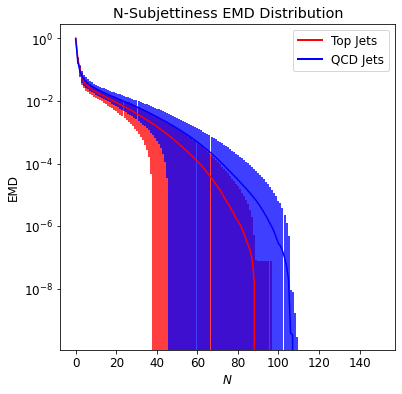

In [ ]:
from matplotlib.lines import Line2D

plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'

sg_ys = [1]
sg_errs = [0]
bg_ys = [1]
bg_errs = [0]

# print(signal_emds, background_emds)

for n in N:
    sg_ys.append(np.mean(signal_emds["%d-Subjettiness" % n]))
    sg_errs.append(np.std(signal_emds["%d-Subjettiness" % n])*1)
    bg_ys.append(np.mean(background_emds["%d-Subjettiness" % n]))
    bg_errs.append(np.std(background_emds["%d-Subjettiness" % n])*1)

plt.errorbar(np.array([0] + list(N)) + 0.1, sg_ys, yerr = sg_errs, color = "red", label = "Top Jets")
plt.errorbar([0] + list(N), bg_ys, yerr = bg_errs, color = "blue", label = "QCD Jets")

# # plt.axhline(np.mean(signal_emds["MAX Subjettiness"]), color = "black")
# plt.axhline(np.mean(signal_emds["Isotropy"] * 0.95), color = "red", linestyle = "--")
# plt.axhline(np.mean(background_emds["Isotropy"] * 0.94), color = "blue", linestyle = "--")


custom_legend = [Line2D([0], [0], color = "red", lw = 2, label = "Top Jets"),
                 Line2D([0], [0], color = "blue", lw = 2, label = "QCD Jets"),
                #  Line2D([0], [0], color = "black", lw = 2, ls = "--", label = r"Isotropy $(\beta = 1)$"),
                 ]
plt.legend(handles = custom_legend)
plt.xlabel(r"$N$")
plt.ylabel("EMD")
plt.yscale("log")
plt.title("N-Subjettiness EMD Distribution")

# TODO: Make rainbow plot CMS vs Pythia plot of N-subjettiness for many Ns 

# Benchmarks - Isotopy
My code vs. Cari's

In [ ]:
ym = 0.8
norm = 12.0/(np.pi*np.pi+16*ym*ym)

# Reference Event
n = 15
points = []
zs = []
for y in np.linspace(-0.8, 0.8, n):
    for phi in np.linspace(-0.8, 0.8, n):

        points.append((y, phi))
        zs.append(1.0 / (n**2))
refernce_event = (np.array(points), np.array(zs))

In [ ]:
from ot.lp import emd2


emds_old = np.zeros(shape = (len(events), N))
times_old = np.zeros(shape = (len(events), N))

def _cdist_phi_y(X,Y, ym):
    # define ym as the maximum rapidity cut on the quasi-isotropic event
    # Make sure the phi values are in range                                                                                                                                          
    phi1 = (X[:,1])
    phi2 = (Y[:,1])
    # Trick to account for phi distance periodicity
    phi_d = ((phi1[:,np.newaxis] - phi2[:])) 
    norm = 12.0/(np.pi*np.pi+16*ym*ym)
    y_d = X[:,0,np.newaxis] - Y[:,0]
    dist = norm * (phi_d**2 + y_d**2)
    return dist

# Calculate the EMDs for each observable, for each event
for (i, event_type) in enumerate(events):
        for (k, event) in enumerate(events[i]):

            t1 = time()
            xi, ai = event
            yj, bj = refernce_event
            M = _cdist_phi_y(xi, yj, 0.8)
            emd_val, log = emd2(ai.astype(np.float64) / ai.sum().astype(np.float64), bj.astype(np.float64)/ bj.sum().astype(np.float64), M,log=True)
            # Should only return 0 when two events are identical. If returning 0 otherwise, problems in config
            if emd_val==0:
                print(log['warning'])
            emds_old[i,k] = emd_val
            t2 = time()
            times_old[i,k] = t2 - t1

            print("Event %d" %k, "Class: %s" % event_labels[i], "Value: %.6f" % emd_val, "Finished in %.3fs" % (t2 - t1))

print(np.sum(times_old))

/home/rikab/miniconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Event 0 Class: signal Value: 0.162718 Finished in 0.003s
Event 1 Class: signal Value: 0.152158 Finished in 0.003s
Event 2 Class: signal Value: 0.181448 Finished in 0.003s
Event 3 Class: signal Value: 0.168805 Finished in 0.003s
Event 4 Class: signal Value: 0.193991 Finished in 0.003s
Event 5 Class: signal Value: 0.148906 Finished in 0.003s
Event 6 Class: signal Value: 0.181966 Finished in 0.003s
Event 7 Class: signal Value: 0.162593 Finished in 0.003s
Event 8 Class: signal Value: 0.167112 Finished in 0.002s
Event 9 Class: signal Value: 0.152554 Finished in 0.003s
Event 10 Class: signal Value: 0.166599 Finished in 0.004s
Event 11 Class: signal Value: 0.166400 Finished in 0.002s
Event 12 Class: signal Value: 0.185009 Finished in 0.002s
Event 13 Class: signal Value: 0.162564 Finished in 0.003s
Event 14 Class: signal Value: 0.176415 Finished in 0.002s
Event 15 Class: signal Value: 0.140186 Finished in 0.003s
Event 16 Class: signal Value: 0.141141 Finished in 0.003s
Event 17 Class: signal V

In [ ]:
labels = ["Isotropy"]
epsilons = [0.0001, 0.001, 0.01, 0.1, 0.99]

emds_sinkhorn = np.zeros(shape = (len(events), len(epsilons), N))
times_sinkhorn = np.zeros(shape = (len(events), len(epsilons)))

def uniform_grid(N, param_dict):

        n = int(np.sqrt(N))
        points = []
        zs = []
        for y in np.linspace(-0.8, 0.8, n):
                for phi in np.linspace(-0.8, 0.8, n):

                        points.append((y, phi))
                        zs.append(1.0 / (n**2))
        return (torch.Tensor(points), torch.Tensor(zs))


isotropy = Observable({}, uniform_grid, beta = 2, R = 1)
shaper = Shaper({"Isotropy": isotropy})


# Calculate the EMDs for each observable, for each event
for (i, event_type) in enumerate(events):
        for (e, eps) in enumerate(epsilons):

                t1 = time()
                emd = shaper.calculate(events[i], epochs= 500, lr = 0.05, beta=2, N = 225, epsilon=eps, scaling = 0.75)
                emds_sinkhorn[i,e,:] = (emd["Isotropy"] * norm).detach().numpy()
                t2 = time()
                times_sinkhorn[i,e] = t2 - t1

                print("Obs: %s-%.1e" % (labels[0], eps), "Class: %s" % event_labels[i], "Finished in %.3fs" % (t2 - t1))

print(np.sum(times_sinkhorn))


TypeError: calculate() got an unexpected keyword argument 'beta'

In [ ]:
plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'

for (e, eps) in enumerate(epsilons):
    print(np.mean(emds_sinkhorn[0,e,:] / norm))
    # plt.hist(emds_old[0,j,:] * 0.5 / 0.8, bins = 25, range=(0.0, 1.125), density = True, color = "red", label = "Signal Old", histtype="stepfilled", alpha = 0.5)
    plt.hist(emds_sinkhorn[0,e,:] , bins = 25, range=(0.00, 0.1), density = True, color = "red", label = "Signal $\epsilon$ = %.1f" % eps, histtype="step", alpha = (len(epsilons)- e) / len(epsilons), lw = 3)
print(np.mean(emds_old[0,:] /2 / emds_sinkhorn[0,0,:]))
plt.hist(emds_old[0,:] /2, bins = 25, range=(0.00, 0.1), density = True, color = "Black", label = "Signal POT", histtype="step", lw = 3)
plt.title(r"Event Isotropy ($25\times25$)" )
plt.xlabel(r"Isotropy" )
plt.ylabel(r"Density" )
plt.legend()
# plt.savefig("Plots/signal_annealing.pdf")
plt.show()
    
plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'

for (e, eps) in enumerate(epsilons):

    # plt.hist(emds_old[1,j,:] * 0.5 / 0.8, bins = 25, range=(0.0, 1.125), density = True, color = "blue", label = "Background Old", histtype="stepfilled", alpha = 0.5)
    plt.hist(emds_sinkhorn[1,e,:] , bins = 25, range=(0.00, 0.1), density = True, color = "blue", label = "Background $\epsilon$ = %.1f" % eps, histtype="step", alpha = (len(epsilons)- e) / len(epsilons), lw = 3)
plt.hist(emds_old[1,:] / 2, bins = 25, range=(0.00, 0.1), density = True, color = "Black", label = "Background POT", histtype="step", lw = 3)
plt.title(r"Event Isotropy ($25\times25$)")
plt.xlabel(r"Isotropy")
plt.ylabel(r"Density" )
plt.legend( )
# plt.savefig("Plots/backgrounds_annealing.pdf")
plt.show()

# for j in range(3):
#     plt.hist(emds_old[1,j,:] * 0.5 / 0.8 , bins = 25, range=(0.0, 1.125), density = True, color = "blue", label = "Background Old", histtype="stepfilled", alpha = 0.5)
#     plt.hist(emds_sinkhorn[1,j,:] * 0.5 / 0.8, bins = 25, range=(0.0, 1.125), density = True, color = "darkblue", label = "Background Sinkhorn", histtype="stepfilled", alpha = 0.5)
#     plt.title(r"$\tau_{%d}$" % (j+1))
#     plt.xlabel(r"$\tau_{%d}$" % (j+1))
#     plt.legend()
#     plt.show()